<a href="https://colab.research.google.com/github/AliEbadi110/Natural-Language-Processing-Text-Classification-Sample-Projects/blob/main/NLP_Transformers_Text_Classification_Sentiment_Analysis_Taaghcheh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLP - Transformers - Text Classification - Sentiment Analysis - Taaghcheh**

In [ ]:
!pip install hazm
!pip install datasets
!pip install transformers[torch]

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from __future__ import unicode_literals
from hazm import *
import re

from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

## 1. Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp '/content/drive/MyDrive/Colab Datasets/kaggle.json' ~/.kaggle

In [ ]:
!kaggle datasets download -d saeedtqp/taaghche

  0% 0.00/6.08M [00:00<?, ?B/s]
100% 6.08M/6.08M [00:00<00:00, 84.7MB/s]


In [ ]:
!unzip taaghche.zip

Archive:  taaghche.zip
  inflating: taghche.csv             


In [ ]:
df = pd.read_csv('/content/taghche.csv', encoding='utf-8')
df = df[['comment', 'rate']]
df.head()

,comment,rate
0,اسم کتاب No one writes to the Colonel\nترجمش...,0.0
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",5.0
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,5.0
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,2.0
4,کتاب خوبی است,3.0


In [ ]:
df.isnull().sum()

comment    21
rate       39
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df['rate'].value_counts()

5.0        39540
4.0         9356
1.0         7930
3.0         7008
2.0         3794
0.0         2144
54374.0        3
4206.0         1
4385.0         1
10053.0        1
12836.0        1
2932.0         1
15965.0        1
17152.0        1
22694.0        1
28912.0        1
38473.0        1
38591.0        1
41097.0        1
42368.0        1
46504.0        1
13482.0        1
Name: rate, dtype: int64

In [ ]:
df = df[df['rate'] <= 5]

In [ ]:
df = df.drop_duplicates(subset=['comment'], keep='first')
df = df.reset_index(drop=True)

In [ ]:
def rate_to_label(rate):
    if rate <= 3:
        return 0
    else:
        return 1


df['label'] = df['rate'].apply(rate_to_label)
df.drop(columns=['rate'], inplace=True)
df.head()

,comment,label
0,اسم کتاب No one writes to the Colonel\nترجمش...,0
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",1
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,1
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,0
4,کتاب خوبی است,0


In [ ]:
#normalize the text
normalizer = Normalizer()

def normal(text):
    text = str(text)
    text = normalizer.correct_spacing(text)
    text = normalizer.remove_diacritics(text)
    text = normalizer.remove_specials_chars(text)
    text = normalizer.persian_style(text)
    text = normalizer.persian_number(text)
    text = normalizer.unicodes_replacement(text)
    text = normalizer.seperate_mi(text)
    text = normalizer.normalize(text)
    return text

#find stopwords in stopwords file
stopwords = []
file = open('/content/drive/MyDrive/Colab Datasets/stopwords-fa.txt').read()
[stopwords.append(x) for x in file.split('\n')]
stopwords = set(stopwords)
len(stopwords)

def remove_stopwords(text):
    text=str(text)
    filtered_tokens = [token for token in text.split() if token not in stopwords]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def remove_emoji(text):
    emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u200c"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r' ', text)

def remove_halfspace(text):
    emoji_pattern = re.compile("["
                u"\u200c"
    "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r' ', text)

def remove_link(text):
    return re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', str(text))
    # return re.sub(r"\bhttps?://\S+", "", str(text))

def remove_picUrl(text):
    return re.sub(r'pic.twitter.com/[\w]*',"", str(text))

def remove_rt(text):
    z = lambda text: re.compile('\#').sub('', re.compile('RT @').sub('@', str(text), count=1).strip())
    return z(text)

def remove_hashtag(text):
    return re.sub(r"#[^\s]+", '', str(text))

def remove_mention(text):
    return re.sub(r"@[^\s]+", '', str(text))

def remove_email(text):
    return re.sub(r'\S+@\S+', '', str(text))

def remove_numbers(text):
    return re.sub(r'^\d+\s|\s\d+\s|\s\d+$', ' ', str(text))

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', str(text))

def remove_quote(text):
    return  str(text).replace("'","")

def remove_chars(text):
    # return re.sub(r'\.(?!\d)', '', str(text))
    return  re.sub(r'[$+&+;+]|[><!+،:’,\(\).+]|[-+]|[…]|[\[\]»«//]|[\\]|[#+]|[_+]|[—+]|[*+]|[؟+]|[?+]|[""]', ' ', str(text))

def remove_englishword(text):
    return re.sub(r'[A-Za-z]+', '', str(text))

def remove_extraspaces(text):
    return re.sub(r' +', ' ', text)

def remove_extranewlines(text):
    return re.sub(r'\n\n+', '\n\n', text)

#lemmatize the text
lemmatizer = Lemmatizer()

def lemma(text):
    text = str(text)
    return lemmatizer.lemmatize(text)

def preprocess(text):
    text = remove_link(text)
    text = remove_picUrl(text)
    text = remove_englishword(text)
    text = normal(text)
    text = remove_stopwords(text)
    text = remove_emoji(text)
    text = remove_rt(text)
    text = remove_mention(text)
    text = remove_emoji(text)
    text = remove_hashtag(text)
    text = remove_email(text)
    text = remove_html(text)
    text = remove_chars(text)
    text = remove_numbers(text)
    text = remove_quote(text)
    text = lemma(text)
    text = remove_extraspaces(text)
    text = remove_extranewlines(text)
    text = remove_halfspace(text)
    text = remove_stopwords(text)
    return text

In [ ]:
df['comment'] = df['comment'].apply(preprocess)
df.head(10)

,comment,label
0,اسم کتاب ترجمش میشه سرهنگ نامه نویسد مترجمی اس...,0
1,طاقچه عزیز کتاب سرهنگ نامه نویسد متن اشتباهست ...,1
2,بنظرم اثر مارکز صد سال تنهایی بخاطرش نوبل ادبی...,1
3,نظر کتاب خوبی میومد ترجمش خوشم نیومد لحنش طوری...,0
4,کتاب خوبی,0
5,راستش خوشم نیومد ازش,0
6,کتابی شیوا بینظیر شاهکار اقای مارکز,1
7,هشت تای داستانها توی کتاب بهترین داستانهای کوت...,0
8,سلام نمونه نداره بدونیم کدوم داستان کوتاه مارک...,0
9,ب جمع بندی رسم ک مارکز جوره نویسنده علاقه,0


In [ ]:
df.label.value_counts()

1    44360
0    19797
Name: label, dtype: int64

<Axes: xlabel='count', ylabel='label'>

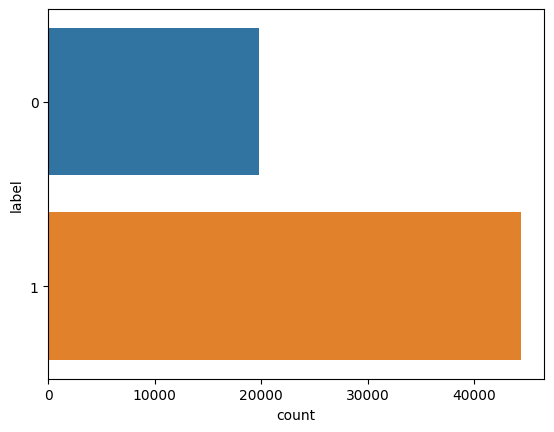

In [ ]:
sns.countplot(data=df, y='label')

In [ ]:
# Handling unbalanced data
negative_data = df[df['label'] == 0]
positive_data = df[df['label'] == 1]

cutting_point = min(len(negative_data), len(positive_data))

if cutting_point <= len(negative_data):
    negative_data = negative_data.sample(n=cutting_point).reset_index(drop=True)

if cutting_point <= len(positive_data):
    positive_data = positive_data.sample(n=cutting_point).reset_index(drop=True)

new_df = pd.concat([negative_data, positive_data])
new_df = new_df.sample(frac=1).reset_index(drop=True)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39594 entries, 0 to 39593
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  39594 non-null  object
 1   label    39594 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 618.8+ KB


In [ ]:
df_train, df_val = train_test_split(new_df, test_size=0.2)
# df_train, df_val = train_test_split(df, test_size=0.2)

In [ ]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "val": Dataset.from_pandas(df_val)
    })

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['comment', 'label', '__index_level_0__'],
        num_rows: 31675
    })
    val: Dataset({
        features: ['comment', 'label', '__index_level_0__'],
        num_rows: 7919
    })
})

In [ ]:
dataset['train'][1]

{'comment': 'امید موفقیت نویسنده گرامی',
 'label': 1,
 '__index_level_0__': 29000}

## 2. Preprocessing

In [ ]:
checkpoint = 'HooshvareLab/bert-fa-base-uncased'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
tokenizer(dataset['train'][1]['comment'], truncation=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [2, 4222, 4710, 5317, 12999, 4], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [ ]:
def tokenize_func(example):
  return tokenizer(example['comment'], truncation=True, max_length=512)

In [ ]:
tokenized_datasets = dataset.map(tokenize_func, batched=True)
tokenized_datasets

Map:   0%|          | 0/31675 [00:00<?, ? examples/s]

Map:   0%|          | 0/7919 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['comment', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31675
    })
    val: Dataset({
        features: ['comment', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7919
    })
})

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## 3. Train Model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
metric1 = load_metric('accuracy')
metric2 = load_metric('f1')

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)
  accuracy = metric1.compute(predictions=predictions, references=labels)["accuracy"]
  f1 = metric2.compute(predictions=predictions, references=labels)["f1"]

  return {"accuracy": accuracy, "f1": f1}

<ipython-input-25-8a7b90626a6b>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric1 = load_metric('accuracy')


In [ ]:
training_args = TrainingArguments('trainer_dir',
                                  per_device_train_batch_size=16,
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  logging_steps=200,
                                  load_best_model_at_end=True,
                                  )

In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['val'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.559800,0.540747,0.721808,0.737956
2,0.440900,0.547193,0.741255,0.736192
3,0.325700,0.677184,0.732668,0.737508


TrainOutput(global_step=5940, training_loss=0.4473909294565117, metrics={'train_runtime': 1861.0963, 'train_samples_per_second': 51.059, 'train_steps_per_second': 3.192, 'total_flos': 4438521115068720.0, 'train_loss': 0.4473909294565117, 'epoch': 3.0})

## 4. Evaluate

In [ ]:
trainer.evaluate()

{'eval_loss': 0.5407471656799316,
 'eval_accuracy': 0.7218083091299407,
 'eval_f1': 0.7379564648507195,
 'eval_runtime': 36.5795,
 'eval_samples_per_second': 216.487,
 'eval_steps_per_second': 27.064,
 'epoch': 3.0}

In [ ]:
val_predictions = trainer.predict(tokenized_datasets['val'])

In [ ]:
val_preds = torch.nn.functional.softmax(torch.Tensor(val_predictions.predictions), dim=-1)

In [ ]:
val_preds = torch.argmax(val_preds, axis=-1)

In [ ]:
print(classification_report(dataset['val']['label'], val_preds.numpy()))

              precision    recall  f1-score   support

           0       0.75      0.66      0.70      3949
           1       0.70      0.78      0.74      3970

    accuracy                           0.72      7919
   macro avg       0.72      0.72      0.72      7919
weighted avg       0.72      0.72      0.72      7919



In [ ]:
print(confusion_matrix(dataset['val']['label'], val_preds.numpy()))

[[2614 1335]
 [ 868 3102]]
